In [1]:
%run ../../shared_setup.ipynb

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [8]:
cnv_exclude_runs = {
    '3d7_hb3': [],
    'hb3_dd2': ['ERR019045', 'ERR019044', ],
    '7g8_gb4': ['ERR027109', 'ERR027117'],
}


# cnv_colors = """
# #1f78b4
# #a6cee3
# #33a02c
# #e31a1c
# #fdbf6f
# #b2df8a
# #fb9a99
# """.strip().split()

cnv_colors = 'bgrcmyk'

def plot_cnv_array(ax, cross, chrom, colors=cnv_colors, **kwargs):
    vcf_fn = COMBINED_VCF_FN_TEMPLATE.format(cross=cross)
    vcf_reader = vcf.Reader(filename=vcf_fn)
    samples = vcf_reader.samples
    parents = vcf_reader.metadata['parents'][0].split(',')
    samples = parents + [s for s in samples if s not in parents]
    samples = [s for s in samples if s.split('/')[2] not in cnv_exclude_runs[cross]]
    runs = [s.split('/')[2] for s in samples]
    cnv_array_fns = [CNV_FN_TEMPLATE.format(run=run, chrom=chrom, window_size=300) for run in runs]
    cnv_arrays = [np.load(fn) for fn in cnv_array_fns]
    cnv_states = np.column_stack([a[:, 3] for a in cnv_arrays])
    anhima.gt.plot_discrete_calldata(cnv_states, samples, colors=colors, states=range(7), ax=ax, **kwargs)
    for i in range(len(samples)):
        ax.axhline(i, color='w', linewidth=.5, alpha=.5)
    ax.yaxis.tick_left()
    ax.set_yticklabels(samples, fontsize=7)
    
    # legend
    states = range(len(colors))
    artists = [plt.Rectangle((0, 0), 1, 1, fc=c) for c in colors]
    labels = ['CN = %s' % s for s in states]
    ax.legend(artists, labels, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=8)


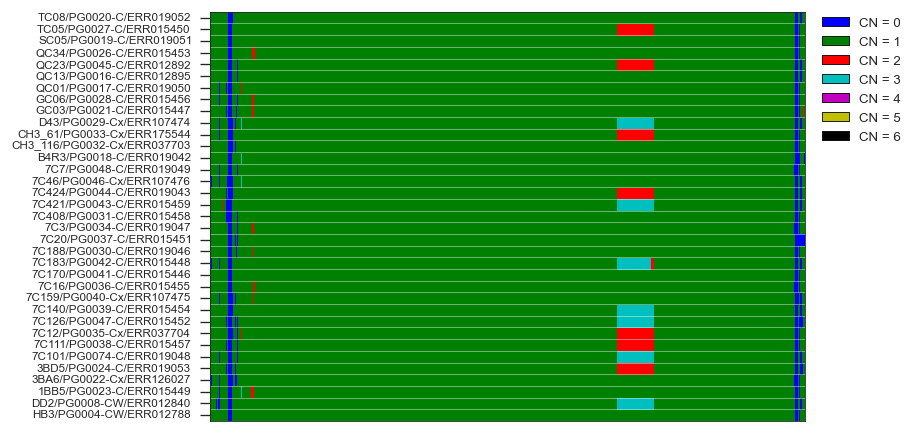

In [10]:
plot_cnv_array(plt.subplot(111), 'hb3_dd2', 'Pf3D7_05_v3')

In [24]:
def plot_cnv_locator(ax, cross, chrom, start=0, stop=None, step=5):
    vcf_fn = COMBINED_VCF_FN_TEMPLATE.format(cross=cross)
    vcf_reader = vcf.Reader(filename=vcf_fn)
    samples = vcf_reader.samples
    parents = vcf_reader.metadata['parents'][0].split(',')
    samples = parents + [s for s in samples if s not in parents]
    runs = [s.split('/')[2] for s in samples]
    cnv_array_fns = [CNV_FN_TEMPLATE.format(run=run, chrom=chrom, window_size=300) for run in runs]
    cnv_array = np.load(cnv_array_fns[0])
    POS = cnv_array[:, 0]
    if stop is None:
        stop = len(fasta[chrom])
    indices = np.nonzero((POS >= start) & (POS <= stop))[0]
    POS = np.take(POS, indices, axis=0)
    anhima.loc.plot_variant_locator(POS, ax=ax, step=step, line_args=dict(color='k'))
    ax.set_xticks([])
    ax.set_xlabel('')


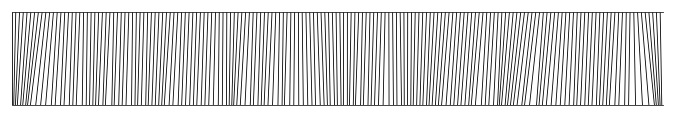

In [25]:
fig = plt.figure(figsize=(7,1))
plot_cnv_locator(plt.gca(), 'hb3_dd2', 'Pf3D7_12_v3', step=20)

In [45]:
def fig_cnv_detail(cross, chrom, annotate_genes=None, gene_labels=None, filename=None):
    vcf_fn = COMBINED_VCF_FN_TEMPLATE.format(cross=cross)
    vcf_reader = vcf.Reader(filename=vcf_fn)
    samples = vcf_reader.samples
    fig = plt.figure(figsize=(7, .15*len(samples)+1))
    gs = mpl.gridspec.GridSpec(4, 1, height_ratios=[.25*len(samples), .4, .4, .6])
    gs.update(hspace=.01, left=.24, right=.88, top=.94, bottom=.13)
    
#     fig.suptitle('B', fontsize=10, fontweight='bold')
    
    ax = fig.add_subplot(gs[0])
    plot_cnv_array(ax, cross, chrom)
    ax.set_xticks([])
    
    ax = fig.add_subplot(gs[1])
    plot_cnv_locator(ax, cross, chrom, step=20)
    
    ax = fig.add_subplot(gs[2])
    plot_accessibility(ax, chrom=chrom, linewidth=.5)
    ax.set_ylabel('accessibility', rotation=0, ha='right', va='center')
    
    ax = fig.add_subplot(gs[3])
#     annotate_genes = ['PF3D7_1224000']
#     gene_labels = {'PF3D7_1224000': 'GCHI'}
    annotate_bbox = dict()
    annotate_arrowprops = dict(arrowstyle='-',
                               connectionstyle='arc3',
                               shrinkA=0, shrinkB=0, linewidth=.5, edgecolor='k')
    plot_genes(ax, chrom, annotate_genes=annotate_genes, gene_labels=gene_labels, annotate_xtext=0,
               annotate_ytext_fwd=14, annotate_bbox=annotate_bbox, annotate_arrowprops=annotate_arrowprops)

    
#     plot_genes(ax, chrom=chrom)
    ax.set_ylabel('genes', rotation=0, ha='right', va='center')
    ax.set_xlabel('chromosome %s position (bp)' % int(chrom[6:8]))
#     for id in annotate_genes:
#         g = lkp_feature[id]
#         l = g['feature_name'] if g['feature_name'] is not None else g['feature_id']
#         if g['feature_strand'] == '+':
#             ax.annotate(l, xy=((g['feature_start'] + g['feature_stop'])/2, .8), xytext=(0, 6), xycoords='data', textcoords='offset points', 
#                         arrowprops=dict(facecolor='k', arrowstyle='-', shrinkA=0, shrinkB=0),
#                         bbox=dict(facecolor='w', alpha=.9))
            
    if filename is not None:
        fig.savefig(filename, dpi=900, jpeg_quality=100)


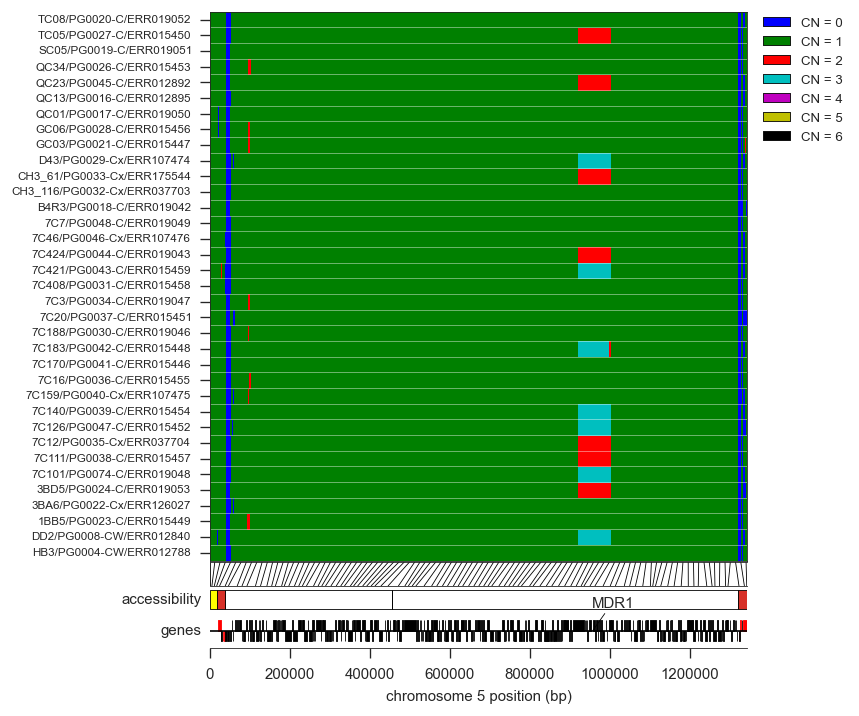

In [46]:
cross = 'hb3_dd2'
chrom = 'Pf3D7_05_v3'
annotate_genes = ['PF3D7_0523000']
gene_labels = {'PF3D7_0523000': 'MDR1'}
filename = '../../artwork/supp/cnv_detail_%s_%s.jpeg' % (chrom, cross)
fig_cnv_detail(cross, chrom, annotate_genes=annotate_genes, gene_labels=gene_labels, filename=filename)